# General notes 

This jupyter notebook is intended to estimate the visibility of flash ionisation features given the telescope parameters and the

In [1]:
import numpy as np
from astropy.io import ascii
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import os
import math
from astropy.table import vstack, Table, hstack
import extinction
import sfdmap
from astropy.coordinates import SkyCoord
import scipy
from fitter_full_code_def import *
from astropy.coordinates import SkyCoord  # High-level coordinates
import sfdmap 
from PyAstronomy import pyasl
from specutils.analysis import snr
from specutils import Spectrum1D
import astropy.units as u
from PyAstronomy import pyasl

ImportError: cannot import name 'BlackBody1D' from 'astropy.modeling.models' (/Users/r.olivaw/anaconda3/envs/py38astro/lib/python3.8/site-packages/astropy/modeling/models.py)

In [ ]:
from matplotlib import rc

rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18


In [ ]:
%matplotlib notebook

In [ ]:
def correct_spectrum(name,spectrum):
    '''
    
    this functiuon corrects the spectrum for extinction and redshift. 
    DO NOT correct prior to SNR estimation (??)
    
    paramters
    ---------
    name     [string] ZTF name of the candidate
    spectrum [table] spectrum 
    
    returns
    -------
    spectrum [table] redshift corrected and extinction corrected
    
    WARNING
    -------
    the varaiable "table_infants" is global and has to be defined prior to the use of this function ... 
    
    
    '''

    tab =  table_infants[table_infants['name']==name]

    z   = tab['redshift'][0]
    co  = SkyCoord (np.array(tab['ra_med'][0]),np.array(tab['dec_med'][0]),unit = 'deg', frame = 'fk5') 


    gal_reddening   = sfdmap.SFDMap('/Volumes/Machiavelli/code_library/python/sfddata-master/', scaling=0.86)
    EBV             = gal_reddening.ebv(co)

#     spectrum        = spectrum[(spectrum['wl']>=4000)&(spectrum['wl']<=8000)]

    spectrum['flux']  = pyasl.unred(spectrum['wl'], spectrum['flux'], EBV)

    #redshift correction
    spectrum['wl']    = spectrum['wl']/(z+1) 
    
    return spectrum



In [ ]:
def estimate_snr_over_band(spec, bandpass = [5000,6000], is_var = False, plot = False):
    '''
    this function estimates the SNR of a spectrum over a specified bandpass
    we assume that your table is ['wl','flux','var']
    
    parameters
    ---------
    spec     [table]
    bandpass [list]
    
    returns
    -------
    snr [float]
    '''
    if is_var is False:
        
        
        signal_portion = spec[(spec.columns[0]>=bandpass[0]) & (spec.columns[0]<=bandpass[-1])]
        
        
        def lin(x,a,b):
            '''
            '''
            return a*x+b

        popt, pcov = curve_fit(lin, signal_portion.columns[0],signal_portion.columns[1])
        
        
        std = np.std(signal_portion.columns[1] - lin(signal_portion.columns[0], *popt))
        
        if plot is True:
            
            f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            ax1.plot(signal_portion.columns[0],signal_portion.columns[1], color = 'black')
            ax1.plot(signal_portion.columns[0],lin(signal_portion.columns[0], *popt), color = 'teal')
            ax1.set_ylabel('Flux')
            
            
            ax2.plot(signal_portion.columns[0], signal_portion.columns[1] - lin(signal_portion.columns[0], *popt),
                     label = f'$\sigma$={std}')
            
            ax2.set_xlabel('Wavelength')
            ax2.set_ylabel('Residual')
            ax2.legend()
            
        
        
        return np.nanmedian(signal_portion.columns[1]/std)
        
    elif is_var is True:
        
        signal_portion = spec[(spec.columns[0]>=bandpass[0])
                                     &(spec.columns[0]<=bandpass[-1])]
       
        return np.nanmedian(signal_portion.columns[1]/np.sqrt(signal_portion.columns[2]))

    

In [ ]:

def bin_spectra(wl, flux, resolution, method = 'mean'):
    '''
    this function bins the input spectrum
    
    parameters
    ----------
    wl [array or list] wavelength
    fluc [array or list] flux array
    resolution size of the wavelength bean 
    method [string] -optional- take the mean or the median in the binsize

    returns
    -------
    astropy table of the binned spec and mean flux in bin
    '''

    number_of_bins = math.floor((wl[-1]-wl[0]) / resolution )   #say we want it every 10 nanometers
    print(number_of_bins) 

    #performs the data rebinning by taking the beam of the fluc value inside the bin
    stat, bin_edge, inde = scipy.stats.binned_statistic(wl, flux, statistic=method, bins = number_of_bins)

    #print(bin_edge)
    #print(stat)

    #takes the mean of the edges of the bin in order to plot the binned spectrum

    bin_wavelength =  [ (bin_edge[i]+ bin_edge[i+1])/2 for i in range(len(bin_edge)-1) ]

    bin_spectra = Table()
    bin_spectra['bin_wl']   = bin_wavelength
    bin_spectra['bin_flux'] = stat

    print('the spectra is binned for a resolution of', resolution)
    return bin_spectra

In [ ]:
def noise_spec(snr, spec, bandpass = [5000,5300]):
    '''
    This function

    
    parameters
    ----------
    SNR 
    spectrum (flux)
    bandpass [list] bandpass for estimating the mean of the spectrum
    
    returns
    -------
    noised flux [array]
    
    '''   
    
    flux  = spec['bin_flux']
    

    mean_flux = np.average( spec[(spec['bin_wl']>=bandpass[0])&(spec['bin_wl']<=bandpass[-1])]['bin_flux'] )
    
    # Generate an sample of white noise
    sigma_noise =  mean_flux/snr
    
    mean_noise = 0
    noise      = np.random.normal(mean_noise, sigma_noise, len(flux))
        
    # Noise up the original signal
    noised_flux = flux + noise
    
    return noised_flux
    
    



# Based on analysis below, we can discrimate a strong flashers down to an SNR of 5 and a weak flasher below 20

### STRONG FLASHERS NUMBERS

In [2]:
sedm_fs_ssnii[sedm_fs_ssnii['FS_SEDm_SNR']<5]

NameError: name 'sedm_fs_ssnii' is not defined

In [3]:
## IMPORTANT NOTE: 4.8 in SNR is rounded up to 5 !!! 

strong_flasher_count = twoday_subsampSNII[twoday_subsampSNII['name']!='ZTF19aatqzrb']



NameError: name 'twoday_subsampSNII' is not defined

In [4]:
# ascii.write(strong_flasher_count, '/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/tables/StrongFlasher_2dsubsample_07042022.csv')

In [5]:
sedm_fs_ssnii[sedm_fs_ssnii['FS_SEDm_SNR']<20]

NameError: name 'sedm_fs_ssnii' is not defined

## /!\ Double check that there's no HR spec afterwaards

In [100]:
delete_useless_spec = list(sedm_fs_ssnii[sedm_fs_ssnii['FS_SEDm_SNR']<15]['name'])

In [101]:
weak_flasher_count = vstack([x for x in twoday_subsampSNII if x['name'] not in delete_useless_spec])

In [102]:
weak_flasher_count

name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g
str12,str10,str4,str6,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18abckutn,SN II,no,SN IIP,2458289.865,2458289.758,2458290.748,DBSP+P200,0.1074884,0.99028249,237.026897,55.7148553,0.040705,0.000123,1999PASP..111..438F,--,--,yes,yes,notype,yes,2458307.69,DBSP+P200,-0.1069391354,0.01501290292,2458289.758,0.98993913,-17.489833262081575,0.00961684735079223,16.19256326104363,0.29419405502410373,-17.511123656906882,0.014952041887626596,9.522573088435623,0.6234607506231766,0.008576205724715288,0.001859420359141762,0.029699745465459428,0.0059168450289302996,9.330205161421391,6.232506273806587
ZTF18abdbysy,SN II,yes?,SN IIP,2458295.705,2458294.781,2458296.4,ACAM+WHT,0.9234606,1.6180685,233.535367,56.6968577,0.012122,0.000175,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458334.75,DBSP+P200,-0.9810973016,0.001930022149,2458294.724,1.6760973,-15.49331020545953,0.0331526327068752,16.85753795836716,0.2862893468098687,-14.505103984137875,0.03272188124838144,10.372182527968567,0.3033303606071478,0.011610440903574113,0.0013302220278154035,0.03011464940724035,0.007192822166535693,10.821940937539091,7.09928796409179
ZTF18abeajml,SN II,yes,SN II,2458303.799,2458302.797,2458304.794,SEDm+P60,1.0019,1.99674769,252.03236,24.3040949,0.036526,8.6e-05,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458331.71,SEDm+P60,-0.02632267313,1.331885814,2458303.773,1.02132267,-18.50264443512861,0.015414958320710454,10.42687184147541,1.5013246095658397,-18.549787640366937,0.007498228090990184,7.372101208620604,1.351557480278869,0.0204867406038592,0.0009898916851182882,0.03619533929041421,0.0026608903799914055,6.572604715042432,4.575926693168947
ZTF18abgqvwv,SN II,yes?,SN IIP,2458313.73,2458312.838,2458314.569,ISIS+WHT,0.8915,1.73143,254.316401,31.9631992,0.037726,9.7e-05,2004SDSS3.C...0000:,--,--,no,yes,notype,yes,2458351.82,DBSP+P200,-1.02018285,0.001249450749,2458312.71,1.85918285,-16.814019840514156,0.006961016565343625,16.7395086276049,0.780814570522296,-16.656944283657296,0.030287354900355737,5.723185790692419,0.6022522133450261,-0.002767699609499243,0.0017236495965795575,0.0069464632463789545,0.0022731549446064706,14.424816825463473,4.47988680579762
ZTF18abokyfk,SN II,yes,SN II,2458350.89,2458349.901,2458352.006,DBSP+P200,0.9891898,2.10471592,2.360629,47.3540827,0.017189,3.3e-05,1999ApJS..121..287H,--,--,yes,yes,Sbc,yes,2458470.335,ACAM+WHT,-0.01311684685,0.00810257263,2458350.877,1.12911685,-17.17781792076166,0.008184648340751678,14.129301377718392,1.0319524497021388,-17.01907663711989,0.0332647297080407,10.042441351563802,1.685214752840058,0.005844303818708419,0.0014540596351276867,0.026480640502759393,0.0014649410130147898,10.31568752100516,6.276399839859646
ZTF18abwlsoi,SN II,yes,SN II,2458377.63,2458376.74,2458377.751,SEDm+P60,0.8952,1.0131723,261.897614,71.530251,0.05376479944,0.007318710553,meas,2458443.6,SEDm+P60,no,yes,--,yes,2458443.6,SEDm+P60,-0.02146235453,0.002665623404,2458377.609,0.14246235,-18.518220748706636,0.29569547023108217,6.291511375496778,0.3851094457398963,-18.581476347170103,0.2963036637351274,4.884686383300792,0.285709373570058,0.031614797151004376,0.008121157616170814,0.045954074587724325,0.007425436176296284,4.868515110202693,3.165895028481702
ZTF18acqwdla,SN II,no,SN II,2458443.874,2458443.789,2458443.937,SEDm+P60,0.0855324,0.1481347,106.472662,12.8929375,

In [103]:
ascii.write(weak_flasher_count, '/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/tables/WeakFlasher_2dsubsample_07042022.csv')

In [519]:
twoday_subsampSNII.show_in_notebook()

idx,name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g
0,ZTF18abckutn,SN II,no,SN IIP,2458289.865,2458289.758,2458290.748,DBSP+P200,0.1074884,0.99028249,237.026897,55.7148553,0.040705,0.000123,1999PASP..111..438F,--,--,yes,yes,notype,yes,2458307.69,DBSP+P200,-0.1069391354,0.01501290292,2458289.758,0.98993913,-17.489833262081575,0.00961684735079223,16.19256326104363,0.29419405502410373,-17.511123656906882,0.014952041887626596,9.522573088435623,0.6234607506231766,0.008576205724715288,0.001859420359141762,0.029699745465459428,0.0059168450289302996,9.330205161421391,6.232506273806587
1,ZTF18abdbysy,SN II,yes?,SN IIP,2458295.705,2458294.781,2458296.4,ACAM+WHT,0.9234606,1.6180685,233.535367,56.6968577,0.012122,0.000175,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458334.75,DBSP+P200,-0.9810973016,0.001930022149,2458294.724,1.6760973,-15.49331020545953,0.0331526327068752,16.85753795836716,0.2862893468098687,-14.505103984137875,0.03272188124838144,10.372182527968567,0.3033303606071478,0.011610440903574113,0.0013302220278154035,0.03011464940724035,0.007192822166535693,10.821940937539091,7.09928796409179
2,ZTF18abeajml,SN II,yes,SN II,2458303.799,2458302.797,2458304.794,SEDm+P60,1.0019,1.99674769,252.03236,24.3040949,0.036526,8.6e-05,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458331.71,SEDm+P60,-0.02632267313,1.331885814,2458303.773,1.02132267,-18.50264443512861,0.015414958320710454,10.42687184147541,1.5013246095658397,-18.549787640366937,0.007498228090990184,7.372101208620604,1.351557480278869,0.0204867406038592,0.0009898916851182882,0.03619533929041421,0.0026608903799914055,6.572604715042432,4.575926693168947
3,ZTF18abgqvwv,SN II,yes?,SN IIP,2458313.73,2458312.838,2458314.569,ISIS+WHT,0.8915,1.73143,254.316401,31.9631992,0.037726,9.7e-05,2004SDSS3.C...0000:,--,--,no,yes,notype,yes,2458351.82,DBSP+P200,-1.02018285,0.001249450749,2458312.71,1.85918285,-16.814019840514156,0.006961016565343625,16.7395086276049,0.780814570522296,-16.656944283657296,0.030287354900355737,5.723185790692419,0.6022522133450261,-0.002767699609499243,0.0017236495965795575,0.0069464632463789545,0.0022731549446064706,14.424816825463473,4.47988680579762
4,ZTF18abokyfk,SN II,yes,SN II,2458350.89,2458349.901,2458352.006,DBSP+P200,0.9891898,2.10471592,2.360629,47.3540827,0.017189,3.3e-05,1999ApJS..121..287H,--,--,yes,yes,Sbc,yes,2458470.335,ACAM+WHT,-0.01311684685,0.00810257263,2458350.877,1.12911685,-17.17781792076166,0.008184648340751678,14.129301377718392,1.0319524497021388,-17.01907663711989,0.0332647297080407,10.042441351563802,1.685214752840058,0.005844303818708419,0.0014540596351276867,0.026480640502759393,0.0014649410130147898,10.31568752100516,6.276399839859646
5,ZTF18abwlsoi,SN II,yes,SN II,2458377.63,2458376.74,2458377.751,SEDm+P60,0.8952,1.0131723,261.897614,71.530251,0.05376479944,0.007318710553,meas,2458443.6,SEDm+P60,no,yes,--,yes,2458443.6,SEDm+P60,-0.02146235453,0.002665623404,2458377.609,0.14246235,-18.518220748706636,0.29569547023108217,6.291511375496778,0.3851094457398963,-18.581476347170103,0.2963036637351274,4.884686383300792,0.285709373570058,0.031614797151004376,0.008121157616170814,0.045954074587724325,0.007425436176296284,4.868515110202693,3.165895028481702
6,ZTF18acqwdla,SN II,no,SN II,2458443.874,2458443.789,2458443.937,SEDm+P60,0.0855324,0.1481347,106.472662,12.8929375,0.026212141,0.004739291488,meas,2458616.456,EFOSC2+NTT,no,yes,--,yes,2458616.456,EFOSC2+NTT,-0.04249999998,0.04249999998,2458443.832,0.1055,-18.60137684700958,0.39262836644613214,12.183829851753528,1.2991954919750475,-18.754296156407,0.39288470141123233,11.513745758265994,0.385908

In [8]:
pwd

'/Users/r.olivaw/Dropbox (Weizmann Institute)/ASTRO/WIP/Full_RISNeII_ZTF1/2dSS_SEDm_analysis'

## SIMULATING FLASH SPECTRA FOR SEDM 

## From a perfect template

We consider  1 order of magnitude difference of mass loss. Same progenitor properties. We consider the 10-2 mass loss as a strong flasher

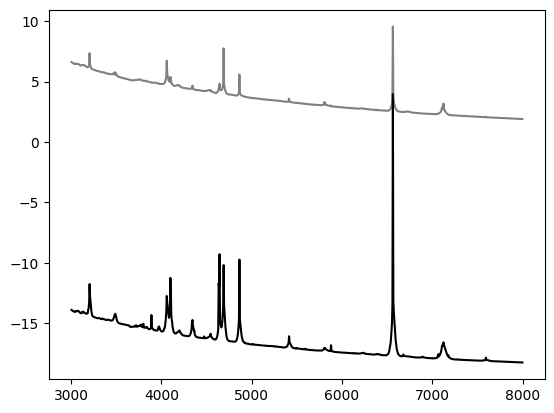

In [9]:
testemp1 = ascii.read('/Users/r.olivaw/Dropbox (Weizmann Institute)/ASTRO/WIP/Flashers/boian_templates/CNO/L1.5e9_Mdot1e-3_Vinf150_R8e13_cno.dat') 
testemp2 = ascii.read('/Users/r.olivaw/Dropbox (Weizmann Institute)/ASTRO/WIP/Flashers/boian_templates/CNO/L1.5e9_Mdot3e-3_Vinf150_R8e13_cno.dat')

# testemp2 = ascii.read('/Users/r.saturn/PhD/WIP/Flashers/boian_templates/CNO/L1.5e9_Mdot1e-2_Vinf150_R8e13_cno.dat')


testemp1 = testemp1[(testemp1['col1']>=3000) & (testemp1['col1']<=8000)]
testemp2 = testemp2[(testemp2['col1']>=3000) & (testemp2['col1']<=8000)]

plt.figure()
plt.plot(testemp1['col1'], testemp1['col2'], color = 'grey')
plt.plot(testemp2['col1'], testemp2['col2']-20, color = 'black')

TNG: 2.52 A/pixel R=585 in the LR-B grism

LT: 4.6 A/pixel, R=350

X-Shooter: 

In [9]:

# WEAK FLASHERS
# TNG
spek11   = pyasl.instrBroadGaussFast(testemp1['col1'], testemp1['col2'], 585, edgeHandling='firstlast', fullout=False, maxsig=None)

# LT
spek12   = pyasl.instrBroadGaussFast(testemp1['col1'], testemp1['col2'], 350, edgeHandling='firstlast', fullout=False, maxsig=None)

# Gemini
spek13   = pyasl.instrBroadGaussFast(testemp1['col1'], testemp1['col2'], 925, edgeHandling='firstlast', fullout=False, maxsig=None)


# STRONG FLASHERS
# TNG
spek21   = pyasl.instrBroadGaussFast(testemp2['col1'], testemp2['col2'], 585, edgeHandling='firstlast', fullout=False, maxsig=None)

# LT
spek22   = pyasl.instrBroadGaussFast(testemp2['col1'], testemp2['col2'], 350, edgeHandling='firstlast', fullout=False, maxsig=None)

# Gemini
spek23   = pyasl.instrBroadGaussFast(testemp2['col1'], testemp2['col2'], 925, edgeHandling='firstlast', fullout=False, maxsig=None)






In [10]:
testemp1['convTNG']  = spek11
testemp1['convLT']   = spek12
testemp1['convGem']   = spek13

testemp2['convTNG']  = spek21
testemp2['convLT']   = spek22
testemp2['convGem']   = spek23




In [11]:
def inject_and_check_SNR(SNR, binned_conv_spec ):
    '''
    
    '''
    
    bin_noise = noise_spec(SNR, binned_conv_spec, bandpass=[5000, 5300])

    
    table_binned_noised_spec      = Table(data = [binned_conv_spec['bin_wl'],bin_noise],names = ('wl','flux'))
    
    print(f'SNR is {estimate_snr_over_band(table_binned_noised_spec,bandpass = [5000,5300])}')
    
    return table_binned_noised_spec

In [12]:
# weak

binned_TNG1       = bin_spectra(testemp1['col1'],testemp1['convTNG'], 5 )
binned_LT1        = bin_spectra(testemp1['col1'],testemp1['convLT'], 5 )
binned_Gem1        = bin_spectra(testemp1['col1'],testemp1['convGem'], 5)




999
the spectra is binned for a resolution of 5
999
the spectra is binned for a resolution of 5
999
the spectra is binned for a resolution of 5


### Injecting a variety of noise levels in the spectra

## starting with the weak mass loss (e10-3)

In [19]:
Gem1_snr_30 = inject_and_check_SNR(30, binned_Gem1 )

SNR is 30.785591508719122


In [22]:

Gem1_snr_20 = inject_and_check_SNR(20, binned_Gem1 )


SNR is 20.306570531413755


In [25]:
Gem1_snr_10 = inject_and_check_SNR(10, binned_Gem1 )

SNR is 10.417095225706655


In [27]:
Gem1_snr_15 = inject_and_check_SNR(15, binned_Gem1 )

SNR is 15.171284558661704


In [29]:
Gem1_snr_5 = inject_and_check_SNR(5, binned_Gem1 )

SNR is 4.725720684714377


In [149]:
# tng1_snr_5

<IPython.core.display.Javascript object>


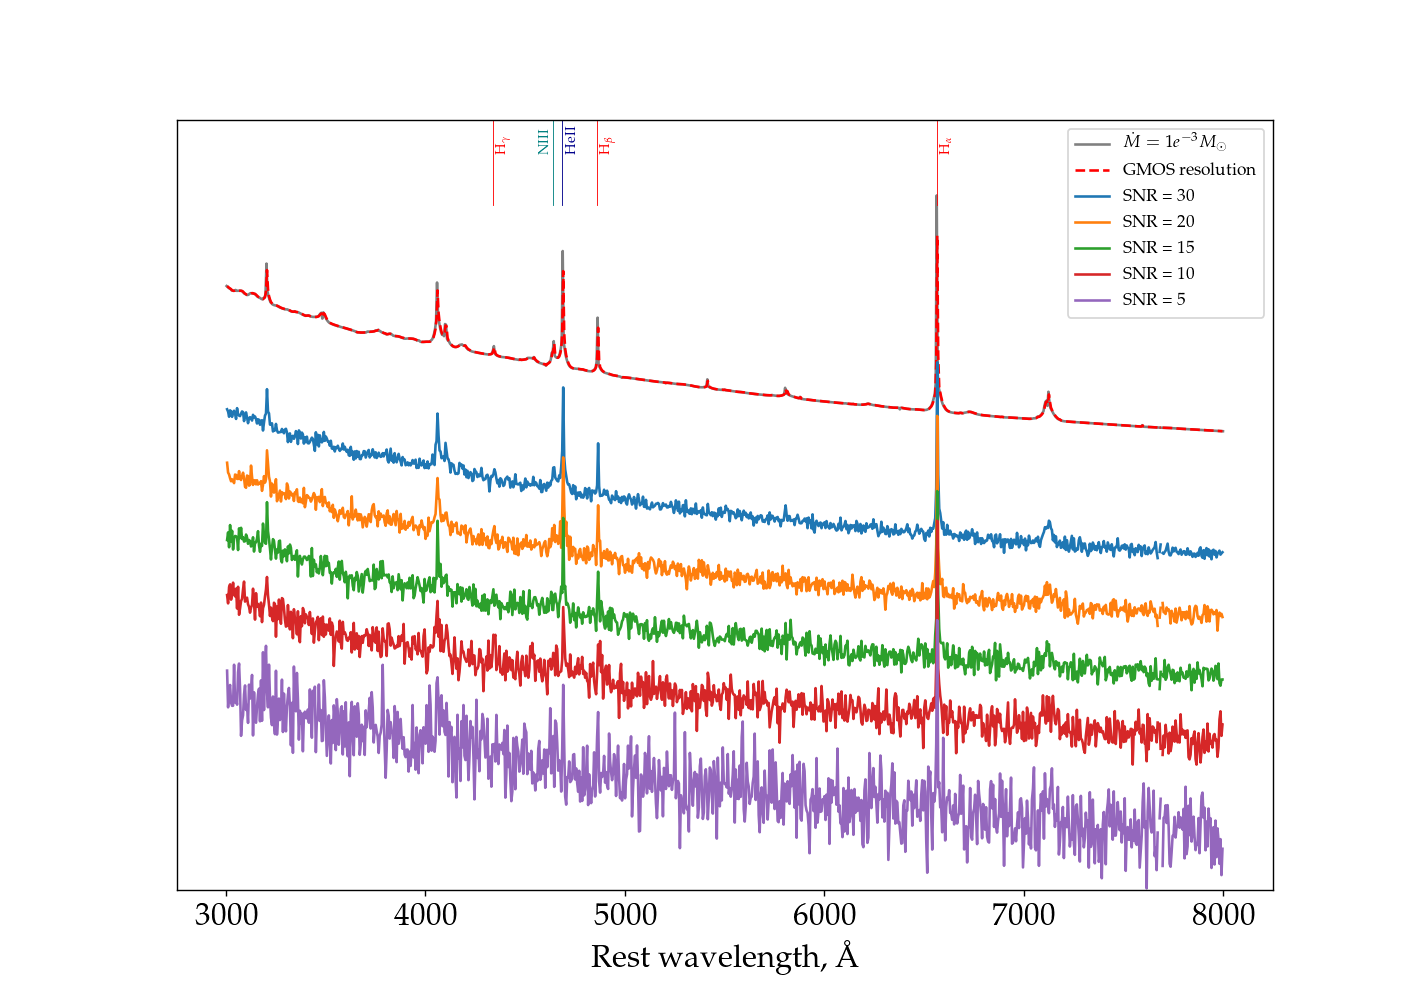

(-11, 14)

In [32]:
plt.figure(figsize = (8*np.sqrt(2),8))
plt.plot(testemp1['col1'], testemp1['col2']+2, color = 'grey', label = '$\dot{M} = 1e^{-3} M_{\odot}$ ')
plt.plot(binned_Gem1['bin_wl'], binned_Gem1['bin_flux']+2, ls = '--',color = 'red',label = 'GMOS resolution' )

plt.plot(Gem1_snr_30['wl'], Gem1_snr_30['flux'] -2, label = 'SNR = 30')
plt.plot(Gem1_snr_20['wl'], Gem1_snr_20['flux'] -4, label = 'SNR = 20')
plt.plot(Gem1_snr_15['wl'], Gem1_snr_15['flux'] -6, label = 'SNR = 15')
plt.plot(Gem1_snr_10['wl'], Gem1_snr_10['flux'] -8, label = 'SNR = 10')
plt.plot(Gem1_snr_5['wl'],  Gem1_snr_5['flux'] - 11, label = 'SNR = 5')


plt.axvline(4686,ymin  = 0.89, ymax = 1, color = 'darkblue', lw = 0.5)
plt.text(4686+20, 13, 'HeII', rotation = 90, color = 'darkblue', size = 8)


plt.axvline(6563, ymin  = 0.89, ymax = 1, color = 'red', lw = 0.5)
plt.text(6563+20, 13, r'H$_{\alpha}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4861, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4861+20, 13, r'H$_{\beta}$', rotation = 90, color = 'red', size = 8)
plt.axvline(4341, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4341+20, 13, r'H$_{\gamma}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4641, ymin  = 0.89, ymax = 1,color = 'teal', lw = 0.5)
plt.text(4641-70, 13, 'NIII', rotation = 90, color = 'teal', size = 8)

plt.yticks([])
plt.legend()
plt.xlabel('Rest wavelength, Å', size = 18)

plt.ylim([-11,14])

In [33]:
plt.savefig('GeminiGMOS_weakflash.eps', format = 'eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# TNG

In [261]:
tng1_snr_30 = inject_and_check_SNR(30, binned_TNG1 )

SNR is 30.513325683043192


In [257]:

tng1_snr_20 = inject_and_check_SNR(20, binned_TNG1 )


SNR is 20.829151288820917


In [265]:
tng1_snr_10 = inject_and_check_SNR(10, binned_TNG1 )

SNR is 9.831938760128057


In [270]:
tng1_snr_15 = inject_and_check_SNR(15, binned_TNG1 )

SNR is 14.84607116370723


In [275]:
tng1_snr_5 = inject_and_check_SNR(5, binned_TNG1 )

SNR is 4.9675403993944


In [149]:
# tng1_snr_5

<IPython.core.display.Javascript object>


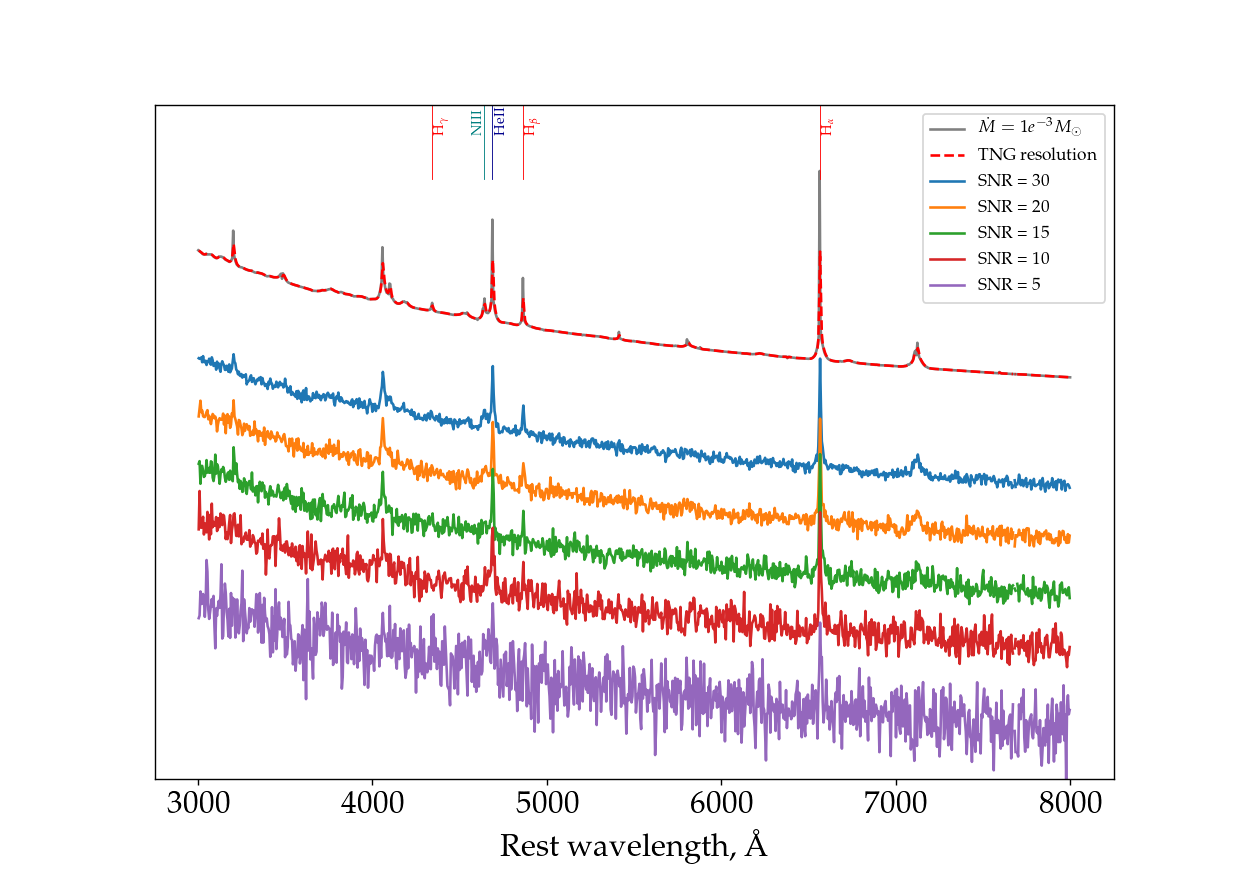

(-11, 14)

In [285]:
plt.figure(figsize = (7*np.sqrt(2),7))
plt.plot(testemp1['col1'], testemp1['col2']+2, color = 'grey', label = '$\dot{M} = 1e^{-3} M_{\odot}$ ')
plt.plot(binned_TNG1['bin_wl'], binned_TNG1['bin_flux']+2, ls = '--',color = 'red',label = 'TNG resolution' )

plt.plot(tng1_snr_30['wl'], tng1_snr_30['flux'] -2, label = 'SNR = 30')
plt.plot(tng1_snr_20['wl'], tng1_snr_20['flux'] -4, label = 'SNR = 20')
plt.plot(tng1_snr_15['wl'], tng1_snr_15['flux'] -6, label = 'SNR = 15')
plt.plot(tng1_snr_10['wl'], tng1_snr_10['flux'] -8, label = 'SNR = 10')
plt.plot(tng1_snr_5['wl'], tng1_snr_5['flux'] - 11, label = 'SNR = 5')


plt.axvline(4686,ymin  = 0.89, ymax = 1, color = 'darkblue', lw = 0.5)
plt.text(4686+20, 13, 'HeII', rotation = 90, color = 'darkblue', size = 8)


plt.axvline(6563, ymin  = 0.89, ymax = 1, color = 'red', lw = 0.5)
plt.text(6563+20, 13, r'H$_{\alpha}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4861, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4861+20, 13, r'H$_{\beta}$', rotation = 90, color = 'red', size = 8)
plt.axvline(4341, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4341+20, 13, r'H$_{\gamma}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4641, ymin  = 0.89, ymax = 1,color = 'teal', lw = 0.5)
plt.text(4641-70, 13, 'NIII', rotation = 90, color = 'teal', size = 8)

plt.yticks([])
plt.legend()
plt.xlabel('Rest wavelength, Å', size = 18)

plt.ylim([-11,14])

In [286]:
plt.savefig('TNG_weakflash.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# LT

In [159]:
lt1_snr_30 = inject_and_check_SNR(30, binned_LT1 )

SNR is 31.051016168087905


In [160]:

lt1_snr_20 = inject_and_check_SNR(20, binned_LT1 )


SNR is 19.073426769651643


In [162]:
lt1_snr_15 = inject_and_check_SNR(15, binned_LT1 )

SNR is 16.95014982004465


In [163]:
lt1_snr_10 = inject_and_check_SNR(10, binned_LT1 )

SNR is 9.77768022535001


In [164]:
lt1_snr_5 = inject_and_check_SNR(5, binned_LT1 )

SNR is 5.360726096115933


<IPython.core.display.Javascript object>


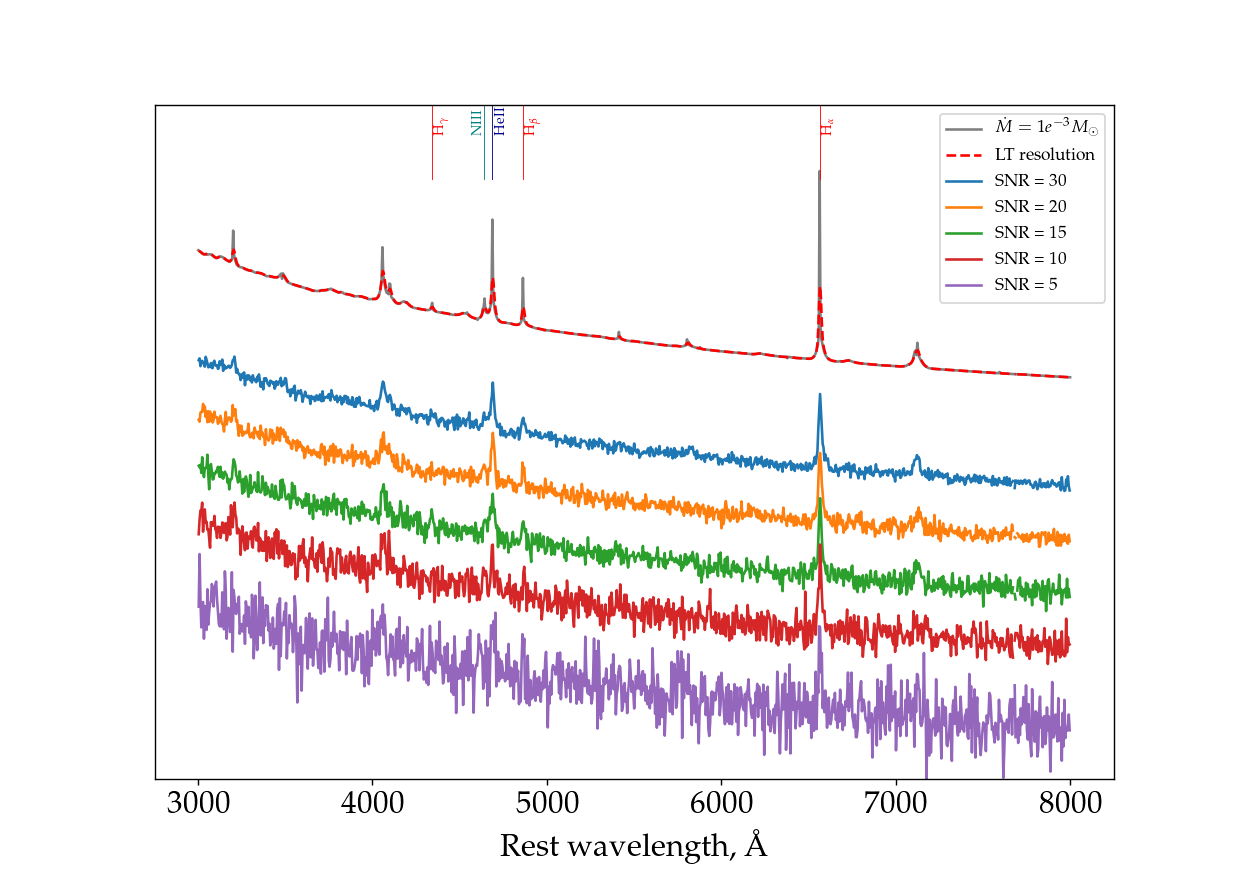

(-11, 14)

In [287]:
plt.figure(figsize = (7*np.sqrt(2),7))
plt.plot(testemp1['col1'], testemp1['col2']+2, color = 'grey', label = '$\dot{M} = 1e^{-3} M_{\odot}$ ')
plt.plot(binned_LT1['bin_wl'], binned_LT1['bin_flux']+2, ls = '--',color = 'red',label = 'LT resolution' )

plt.plot(lt1_snr_30['wl'], lt1_snr_30['flux'] -2, label = 'SNR = 30')
plt.plot(lt1_snr_20['wl'], lt1_snr_20['flux'] -4, label = 'SNR = 20')
plt.plot(lt1_snr_15['wl'], lt1_snr_15['flux'] -6, label = 'SNR = 15')
plt.plot(lt1_snr_10['wl'], lt1_snr_10['flux'] -8, label = 'SNR = 10')
plt.plot(lt1_snr_5['wl'], lt1_snr_5['flux'] - 11, label = 'SNR = 5')


plt.axvline(4686,ymin  = 0.89, ymax = 1, color = 'darkblue', lw = 0.5)
plt.text(4686+20, 13, 'HeII', rotation = 90, color = 'darkblue', size = 8)


plt.axvline(6563, ymin  = 0.89, ymax = 1, color = 'red', lw = 0.5)
plt.text(6563+20, 13, r'H$_{\alpha}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4861, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4861+20, 13, r'H$_{\beta}$', rotation = 90, color = 'red', size = 8)
plt.axvline(4341, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4341+20, 13, r'H$_{\gamma}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4641, ymin  = 0.89, ymax = 1,color = 'teal', lw = 0.5)
plt.text(4641-70, 13, 'NIII', rotation = 90, color = 'teal', size = 8)

plt.yticks([])
plt.legend()
plt.xlabel('Rest wavelength, Å', size = 18)

plt.ylim([-11,14])

In [288]:
plt.savefig('LT_weakflash.eps', format = 'eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## continue with stronger massloss (3e-3modot/yr)

In [34]:
binned_TNG2       = bin_spectra(testemp2['col1'],testemp2['convTNG'], 6 )
binned_LT2        = bin_spectra(testemp2['col1'],testemp2['convLT'], 6 )
binned_Gem2        = bin_spectra(testemp2['col1'],testemp2['convGem'], 6 )


832
the spectra is binned for a resolution of 6
832
the spectra is binned for a resolution of 6
832
the spectra is binned for a resolution of 6


# Gemini

In [53]:
Gem2_snr_30 = inject_and_check_SNR(30, binned_Gem2 )


SNR is 30.95428977760579


In [57]:

Gem2_snr_20 = inject_and_check_SNR(20, binned_Gem2 )


SNR is 21.12260143244096


In [64]:
Gem2_snr_15 = inject_and_check_SNR(15, binned_Gem2 )

SNR is 15.946215996838148


In [68]:
Gem2_snr_10 = inject_and_check_SNR(10, binned_Gem2 )

SNR is 10.910289155849195


In [69]:
Gem2_snr_5 = inject_and_check_SNR(5, binned_Gem2 )

SNR is 4.855305194084528


<IPython.core.display.Javascript object>


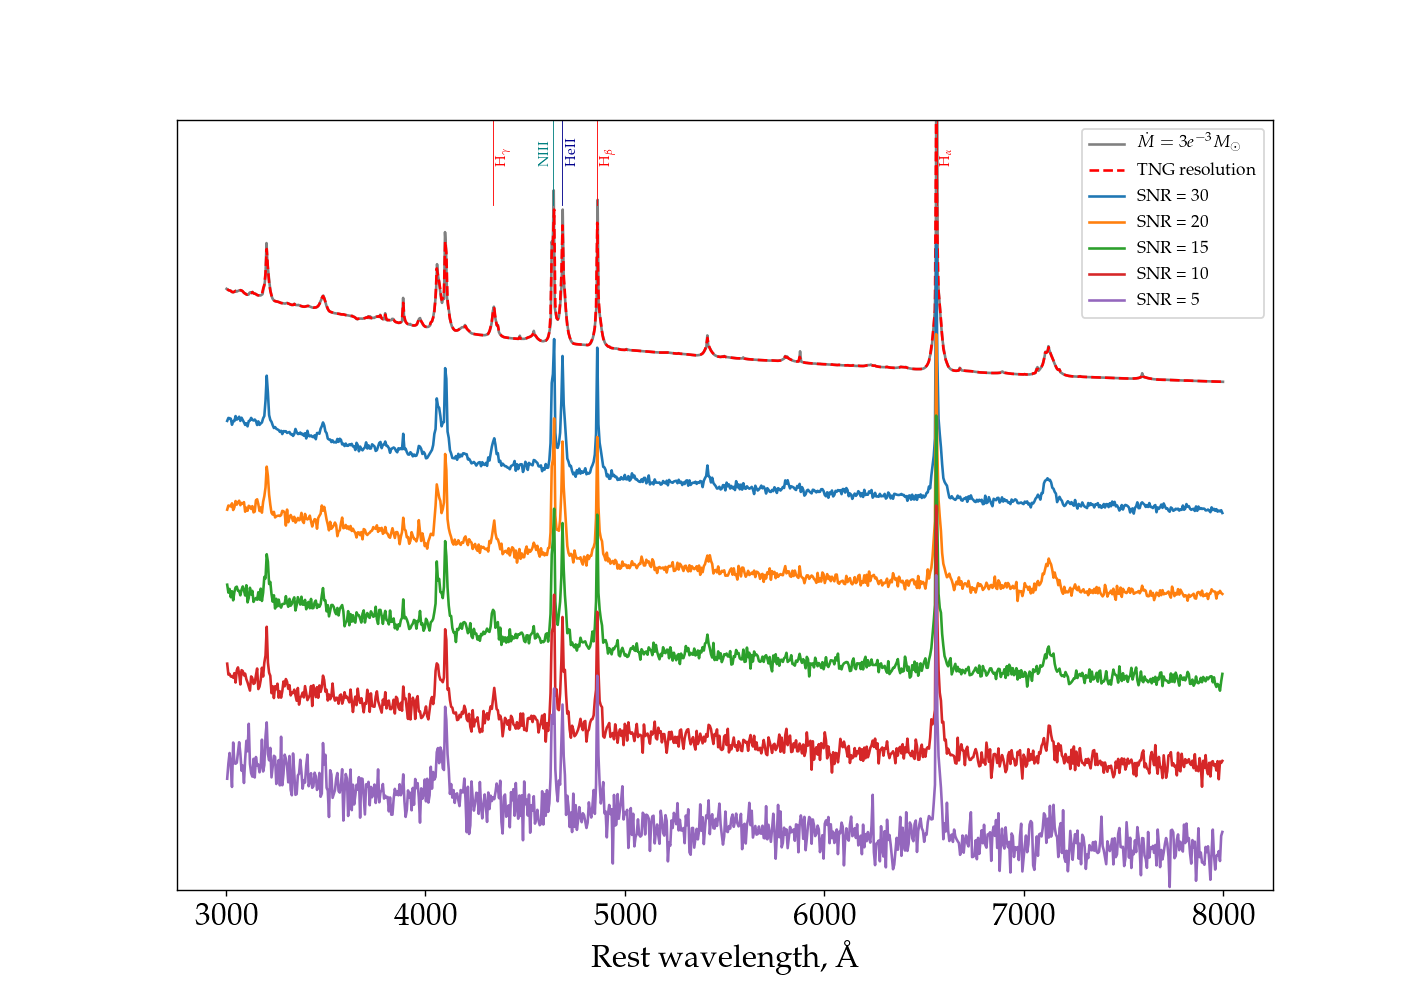

(-21, 15)

In [70]:
plt.figure(figsize = (8*np.sqrt(2),8))
plt.plot(testemp2['col1'], testemp2['col2']+1, color = 'grey', label = '$\dot{M} = 3e^{-3} M_{\odot}$ ' )
plt.plot(binned_Gem2['bin_wl'], binned_Gem2['bin_flux']+1, ls = '--',color = 'red',label = 'TNG resolution')



plt.plot(Gem2_snr_30['wl'], Gem2_snr_30['flux'] -5, label = 'SNR = 30')
plt.plot(Gem2_snr_20['wl'], Gem2_snr_20['flux'] -9, label = 'SNR = 20')
plt.plot(Gem2_snr_15['wl'], Gem2_snr_15['flux'] -13,  label = 'SNR = 15')
plt.plot(Gem2_snr_10['wl'], Gem2_snr_10['flux'] -17,  label = 'SNR = 10')
plt.plot(Gem2_snr_5['wl'],  Gem2_snr_5['flux'] -21,  label = 'SNR = 5')
# plt.plot(binned_sedm2['bin_wl'], bin_noise_sedm2_3 -15,  label = 'SNR = 3')




plt.axvline(4686,ymin  = 0.89, ymax = 1, color = 'darkblue', lw = 0.5)
plt.text(4686+20, 13, 'HeII', rotation = 90, color = 'darkblue', size = 8)


plt.axvline(6563, ymin  = 0.89, ymax = 1, color = 'red', lw = 0.5)
plt.text(6563+20, 13, r'H$_{\alpha}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4861, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4861+20, 13, r'H$_{\beta}$', rotation = 90, color = 'red', size = 8)
plt.axvline(4341, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4341+20, 13, r'H$_{\gamma}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4641, ymin  = 0.89, ymax = 1,color = 'teal', lw = 0.5)
plt.text(4641-70, 13, 'NIII', rotation = 90, color = 'teal', size = 8)

plt.yticks([])
plt.legend()
plt.xlabel('Rest wavelength, Å', size = 18)

plt.ylim([-21,15])


In [71]:
plt.savefig('GeminiGMOS_strongflash.eps', format = 'eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# LT

In [228]:
lt2_snr_30 = inject_and_check_SNR(30, binned_LT2 )

SNR is 30.2243712152543


In [235]:

lt2_snr_20 = inject_and_check_SNR(20, binned_LT2 )


SNR is 20.791676763413776


In [237]:
lt2_snr_15 = inject_and_check_SNR(15, binned_LT2 )

SNR is 15.305002261549781


In [242]:
lt2_snr_10 = inject_and_check_SNR(10, binned_LT2 )

SNR is 10.401748723432164


In [243]:
lt2_snr_5 = inject_and_check_SNR(5, binned_LT2 )

SNR is 5.355102662202268


<IPython.core.display.Javascript object>


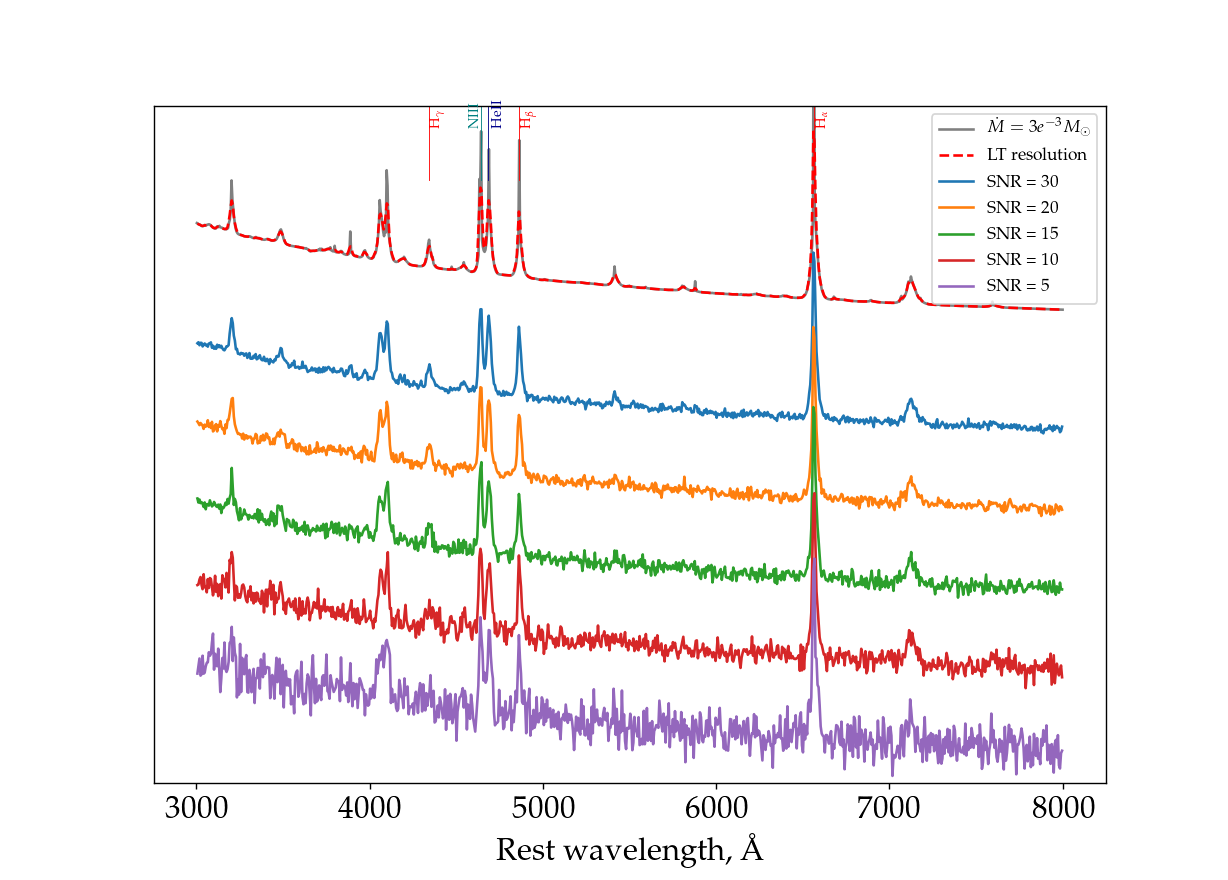

(-20, 14)

In [251]:
plt.figure(figsize = (6*np.sqrt(2),6))
plt.plot(testemp2['col1'], testemp2['col2']+2, color = 'grey', label = '$\dot{M} = 3e^{-3} M_{\odot}$ ')
plt.plot(binned_LT2['bin_wl'], binned_LT2['bin_flux']+2, ls = '--',color = 'red',label = 'LT resolution' )

plt.plot(lt2_snr_30['wl'], lt2_snr_30['flux'] -4, label = 'SNR = 30')
plt.plot(lt2_snr_20['wl'], lt2_snr_20['flux'] -8, label = 'SNR = 20')
plt.plot(lt2_snr_15['wl'], lt2_snr_15['flux'] -12, label = 'SNR = 15')
plt.plot(lt2_snr_10['wl'], lt2_snr_10['flux'] -16, label = 'SNR = 10')
plt.plot(lt2_snr_5['wl'],  lt2_snr_5['flux'] - 20, label = 'SNR = 5')


plt.axvline(4686,ymin  = 0.89, ymax = 1, color = 'darkblue', lw = 0.5)
plt.text(4686+20, 13, 'HeII', rotation = 90, color = 'darkblue', size = 8)


plt.axvline(6563, ymin  = 0.89, ymax = 1, color = 'red', lw = 0.5)
plt.text(6563+20, 13, r'H$_{\alpha}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4861, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4861+20, 13, r'H$_{\beta}$', rotation = 90, color = 'red', size = 8)
plt.axvline(4341, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4341+20, 13, r'H$_{\gamma}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4641, ymin  = 0.89, ymax = 1,color = 'teal', lw = 0.5)
plt.text(4641-70, 13, 'NIII', rotation = 90, color = 'teal', size = 8)

plt.yticks([])
plt.legend()
plt.xlabel('Rest wavelength, Å', size = 18)

plt.ylim([-20,14])

## Conclusion 

For strong flashers, the SNR cut for SEDm is whichever is below 5. For weak flashers, the SNR cut is below 20 (15 to be conservative)

## Degrading a HR spec to SEDm res 

In [214]:
HR_spec = twoday_subsampSNII[twoday_subsampSNII['instrument-fs']!='SEDm+P60']

In [215]:
HR_spec_flash = HR_spec[HR_spec['Flasher']=='yes']

In [216]:
HR_spec_flash

name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g
str12,str10,str4,str6,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18abokyfk,SN II,yes,SN II,2458350.89,2458349.901,2458352.006,DBSP+P200,0.9891898,2.10471592,2.360629,47.3540827,0.017189,3.3e-05,1999ApJS..121..287H,--,--,yes,yes,Sbc,yes,2458470.335,ACAM+WHT,-0.01311684685,0.00810257263,2458350.877,1.12911685,-17.17781792076166,0.008184648340751678,14.129301377718392,1.0319524497021388,-17.01907663711989,0.0332647297080407,10.042441351563802,1.685214752840058,0.005844303818708419,0.0014540596351276867,0.026480640502759393,0.0014649410130147898,10.31568752100516,6.276399839859646
ZTF19abueupg,SN II,yes,SN II,2458724.65,2458723.81,2458725.0,KAST+Lick,0.8381,1.05203241,267.80329,51.3825496,0.017,0.005,superfit,2458728.5,KAST+Lick,yes,yes,--,no?,2458726.867,LRIS+Keck,-0.06598457236,0.01248434827,2458724.584,0.41598457,-16.95681076130405,0.3773607420941401,7.308715897967324,0.24736832618732948,-17.02767166159192,0.37741020899787786,7.090234361829822,0.3435141398378344,0.004205001496146869,0.0016525030563393777,0.023564288696171647,0.0033249787331478004,6.125237700242728,5.283687875084523
ZTF19acryurj,SN II,yes,SN II,2458800.79,2458799.805,2458801.991,GMOS+Gemini,0.9845,2.18556632,13.5933959,31.6701819,0.022035,3e-05,1999PASP..111..438F,--,--,yes,yes,Scd,yes,2458851.68,SEDm+P60,-0.7930354097,0.03180023974,2458799.997,1.99403541,-18.174868362848947,0.019641623004026457,12.474288294860525,1.653309210781393,-18.020185604926763,0.002957939871472252,15.14928994756515,0.11212448745559071,0.01811168499078665,0.0008267861935223747,0.035946359943563766,0.0012075309354014595,8.863190847760377,9.130079328154752
ZTF20ablygyy,SN II,yes,SN II,2459046.698,2459045.754,2459047.403,DOLORES+TNG,0.9434,1.64900626,225.958184,42.1140315,0.016872,2.3e-05,1993A&AS..102...57B,--,--,yes,yes,Sbab,yes,2459114.661,SEDm+P60,-0.1589595728,0.03148805308,2459046.539,0.86395957,-18.247998349089393,0.010482662682663664,11.01065398248554,0.27187684849252963,-18.265771872920766,0.004435145395014,6.268145184466201,0.5263487480959356,0.02933718847128311,0.0011283151366253737,0.029054072514433423,0.002394936123568392,7.190677980323218,4.608315096647424
ZTF20abqwkxs,SN II,yes,SN II,2459070.704,2459069.799,2459072.391,DOLORES+TNG,0.9044,2.5917425,224.868111,73.8986784,0.023903,7.3e-05,1999PASP..111..438F,--,--,yes,yes,SB( rs )b,yes,2459106.36,ALFOSC+NOT,-0.0059537608,0.02928073503,2459070.698,1.69295376,-15.882131526378505,0.008152407406464597,6.257557109518112,0.9150995631946598,-15.942872987745261,0.011461420029917421,4.718539994470884,0.5506076857442014,0.005031654343084986,0.009549441484546353,0.02348211608489761,0.010991320559639962,4.95901176473825,2.435593317404531
ZTF20abxyjtx,SN II,yes,SN II,2459093.634,2459091.716,2459094.375,ALFOSC+NOT,1.9185,2.65930737,236.937978,28.6403193,0.033224,7.4e-05,2005SDSS4.C...0000:,--,--,yes,yes,Sc,yes?,2459109.71,SEDm+P60,-0.1503734545,0.008119565927,2459093.484,0.89137345,-17.874252686716996,0.2930944493524925,12.370434607127184,1.5730743903924373,99.0,99.0,99.0,99.0,0.02515258671397581,0.0028321342239474266,99.0,99.0,99.0,99.0


## ZTF19acryurj

In [272]:
len(urj)

3158

In [495]:
urj = ascii.read('/Volumes/Machiavelli/WIP/Full_Infant_SNeII/data/2019/ZTF19acryurj/spectroscopy/ZTF19acryurj_20191114_Gemini_N_v1.ascii',
                              names = ['wl','flux'])
# urj['flux'] /= np.median(urj[(urj['wl']<6000)&(urj['wl']>5000)]['flux'])

In [496]:
urj = correct_spectrum('ZTF19acryurj',urj)

In [497]:
estimate_snr_over_band(urj, bandpass=[4100,4500])

22.96857073867873

In [498]:
interp_flux = interp1d(urj['wl'], urj['flux'] ,  bounds_error=False, fill_value='nan')
interp_wl   = np.linspace(min(urj['wl']), max(urj['wl']), 4000)

sedm_urj_sim = Table(data=([interp_wl,interp_flux(interp_wl)]), names = ('wl', 'flux'))

In [499]:


spek1   = pyasl.instrBroadGaussFast(sedm_urj_sim['wl'], sedm_urj_sim['flux'], 100, edgeHandling='firstlast', fullout=False, maxsig=None)
sedm_urj_sim['convSEDm']  = spek1


binned_sedm    = bin_spectra(sedm_urj_sim['wl'],sedm_urj_sim['convSEDm'], 30 )

104
the spectra is binned for a resolution of 30


In [500]:
noised_flux_Sedm = noise_spec(snr = 23, spec = binned_sedm, bandpass=[4100,4500])
binned_sedm['noised_flux'] = noised_flux_Sedm

In [501]:
estimate_snr_over_band(binned_sedm, bandpass=[4100,4500])

29.45687162753354

In [502]:
var_sedmsim       = np.var(binned_sedm[(binned_sedm['bin_wl']>=4100)&(binned_sedm['bin_wl']<=4500)]['noised_flux'])

test_snr_sedm_sim = binned_sedm[(binned_sedm['bin_wl']>=4100)&(binned_sedm['bin_wl']<=4500)]

urj_snr_semdsim   = np.nanmedian(test_snr_sedm_sim['noised_flux']/np.sqrt(var_sedmsim))

In [503]:
urj_snr_semdsim

22.430374374214757

In [243]:
# target    = snr*np.sqrt(var) 
# mean_flux = np.average( spec[(spec['bin_wl']>=4100)&(spec['bin_wl']<=5500)]['bin_flux'] )

# # Generate an sample of white noise
# sigma_noise = target - mean_flux

# mean_noise = 0
# noise      = np.random.normal(mean_noise, np.sqrt(sigma_noise), len(flux))

In [504]:
real_sedm_urj = ascii.read('/Volumes/Machiavelli/WIP/Full_Infant_SNeII/data/2019/ZTF19acryurj/spectroscopy/ZTF19acryurj_20191115_P60_v1.ascii',
                          names = ['wl','flux','var'])

In [505]:
real_sedm_urj = correct_spectrum('ZTF19acryurj',real_sedm_urj)

In [506]:
var     = np.var(real_sedm_urj[(real_sedm_urj['wl']>=4100)&(real_sedm_urj['wl']<=4500)]['flux'])

test_snr = real_sedm_urj[(real_sedm_urj['wl']>=4100)&(real_sedm_urj['wl']<=4500)]

urj_snr = np.nanmedian(test_snr['flux']/np.sqrt(var))
urj_snr

14.523765859694864

<IPython.core.display.Javascript object>


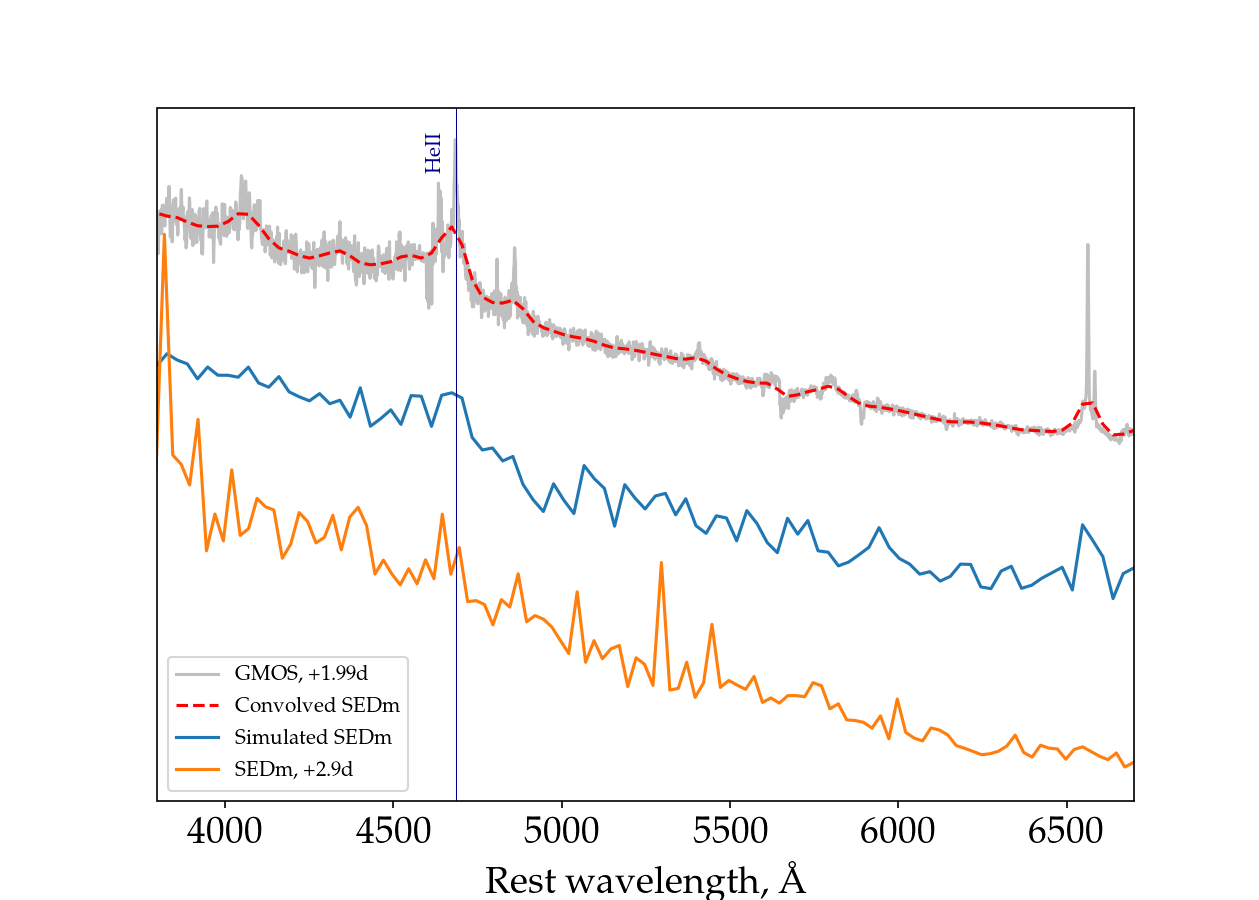

Text(0.5, 0, 'Rest wavelength, Å')

In [516]:

norma_real_sedm = np.median(real_sedm_urj[(real_sedm_urj['wl']>4000)&(real_sedm_urj['wl']<5000)]['flux'])
norma_real_gem  = np.median(urj[(urj['wl']>4000)&(urj['wl']<5000)]['flux'])

plt.figure(figsize = (6*1.4,6))
# plt.title('Redshift corrected, ISM redd corrected')
plt.plot(urj['wl'], urj['flux']/norma_real_gem, alpha = 0.5, color = 'grey', label = 'GMOS, +1.99d')
plt.plot(binned_sedm['bin_wl'], binned_sedm['bin_flux']/norma_real_gem, ls = '--', color = 'red', label = 'Convolved SEDm')

plt.plot(binned_sedm['bin_wl'], binned_sedm['noised_flux']/norma_real_gem- 0.5, label = 'Simulated SEDm')

plt.plot(real_sedm_urj['wl'],  real_sedm_urj['flux']/norma_real_sedm -1, label = 'SEDm, +2.9d ')




plt.axvline(4686, color = 'darkblue', lw = 0.5) 
plt.text(4686-90, 1.3, 'HeII', color = 'darkblue', rotation = 90)

plt.xlim([3800,6700])
plt.ylim([-0.8,1.5])


plt.yticks([])
plt.legend()
plt.xlabel('Rest wavelength, Å', size = 18)

In [517]:
plt.savefig('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/figures/flasher_statistics/19ust_sedmsim.pdf')

If we didn't have Gemini, we would'nt have caught it 

# ZTF19acignlo

In [457]:
nlo = ascii.read('/Volumes/Machiavelli/WIP/Full_Infant_SNeII/data/2019/ZTF19acignlo/spectroscopy/SN2019tjt_2019-10-31_02-19-27_VLT-UT1_FORS2_TNS.dat',
                              names = ['wl','flux'])
# urj['flux'] /= np.median(urj[(urj['wl']<6000)&(urj['wl']>5000)]['flux'])



In [458]:
nlo = correct_spectrum('ZTF19acignlo',nlo)

In [459]:
estimate_snr_over_band(nlo, bandpass=[4100,4500])

15.026155783947411

In [460]:

interp_flux = interp1d(nlo['wl'], nlo['flux'] ,  bounds_error=False, fill_value='nan')
interp_wl   = np.linspace(min(nlo['wl']), max(nlo['wl']), 4000)


In [461]:
sedm_nlo_sim = Table(data=([interp_wl,interp_flux(interp_wl)]), names = ('wl', 'flux'))

In [462]:
spek1   = pyasl.instrBroadGaussFast(sedm_nlo_sim['wl'], sedm_nlo_sim['flux'], 100, edgeHandling='firstlast', fullout=False, maxsig=None)
sedm_nlo_sim['convSEDm']  = spek1


binned_sedm    = bin_spectra(sedm_nlo_sim['wl'],sedm_nlo_sim['convSEDm'], 30 )

187
the spectra is binned for a resolution of 30


In [468]:
noised_flux_Sedm = noise_spec(snr = 15, spec = binned_sedm, bandpass=[4100,4500])
binned_sedm['noised_flux'] = noised_flux_Sedm

In [467]:
# var_sedmsim       = np.var(binned_sedm[(binned_sedm['bin_wl']>=4100)&(binned_sedm['bin_wl']<=4500)]['bin_flux'])

# test_snr_sedm_sim = binned_sedm[(binned_sedm['bin_wl']>=4100)&(binned_sedm['bin_wl']<=4500)]

# sedm_nlo_sim   = np.nanmedian(binned_sedm['bin_flux']/np.sqrt(var_sedmsim))

# sedm_nlo_sim


In [470]:

var_sedmsim       = np.var(binned_sedm[(binned_sedm['bin_wl']>=4100)&(binned_sedm['bin_wl']<=4500)]['noised_flux'])

test_snr_sedm_sim = binned_sedm[(binned_sedm['bin_wl']>=4100)&(binned_sedm['bin_wl']<=4500)]

sedm_nlo_sim   = np.nanmedian(test_snr_sedm_sim['noised_flux']/np.sqrt(var_sedmsim))

sedm_nlo_sim

11.391286840749899

In [471]:

real_sedm_nlo = ascii.read('/Volumes/Machiavelli/WIP/Full_Infant_SNeII/data/2019/ZTF19acignlo/spectroscopy/ZTF19acignlo_20191030_P60_v2.ascii',
                          names = ['wl','flux','var'])

real_sedm_nlo = correct_spectrum('ZTF19acignlo',real_sedm_nlo)

var     = np.var(real_sedm_nlo[(real_sedm_nlo['wl']>=4100)&(real_sedm_nlo['wl']<=4500)]['flux'])

test_snr = real_sedm_nlo[(real_sedm_nlo['wl']>=4100)&(real_sedm_nlo['wl']<=4500)]

nlo_snr = np.nanmedian(test_snr['flux']/np.sqrt(var))
nlo_snr

9.46316444326823

<IPython.core.display.Javascript object>


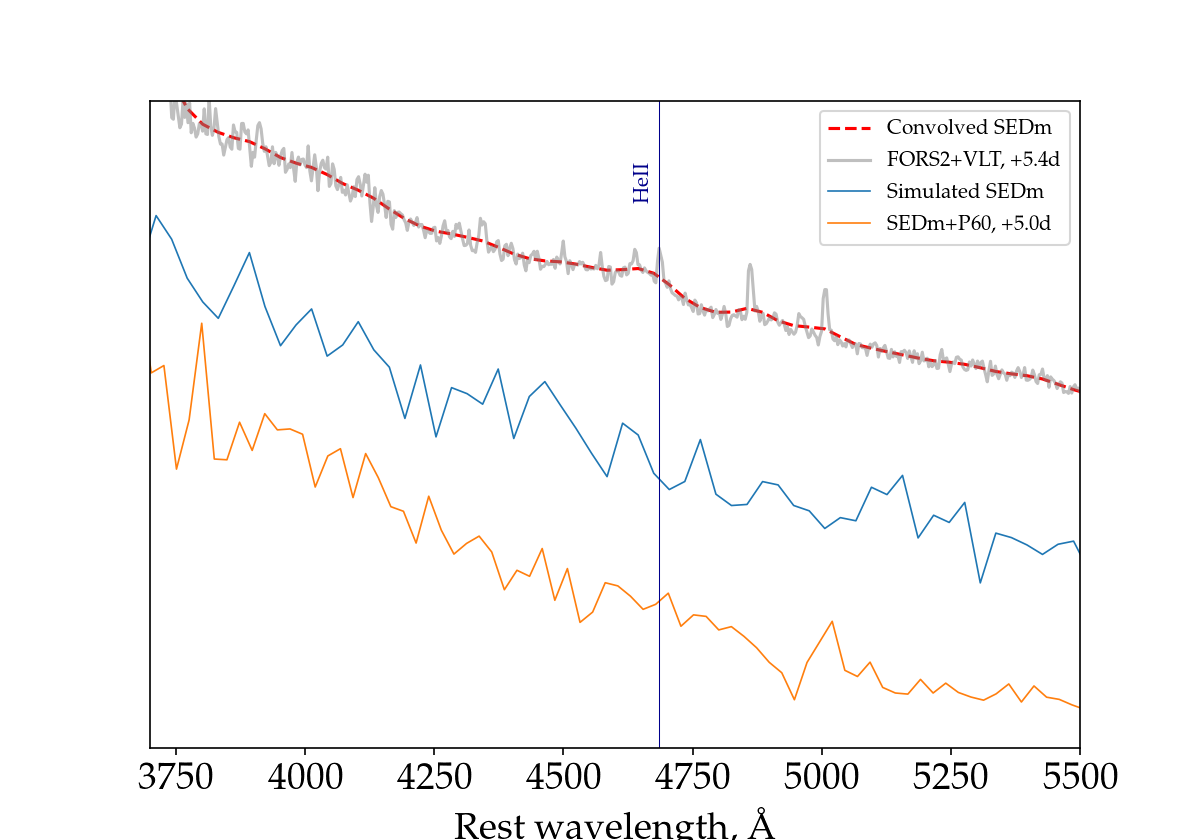

(-0.5, 1.5)

In [493]:

norma_real_sedm = np.median(real_sedm_nlo[(real_sedm_nlo['wl']>4000)&(real_sedm_nlo['wl']<5000)]['flux'])
norma_real_gem  = np.median(nlo[(nlo['wl']>4000)&(nlo['wl']<5000)]['flux'])

plt.figure()
# plt.title('Redshift corrected, ISM redd corrected')
plt.plot(binned_sedm['bin_wl'], binned_sedm['bin_flux']/norma_real_gem, ls = '--', color = 'red', label = 'Convolved SEDm')
plt.plot(nlo['wl'], nlo['flux']/norma_real_gem, alpha = 0.5, color = 'grey', label = 'FORS2+VLT, +5.4d')


plt.plot(binned_sedm['bin_wl'], binned_sedm['noised_flux']/norma_real_gem - 0.5, lw = 0.8, label = 'Simulated SEDm')

plt.plot(real_sedm_nlo['wl'],  real_sedm_nlo['flux']/norma_real_sedm -1,lw = 0.8 , label = 'SEDm+P60, +5.0d')

# plt.fill_between(spec['wl'], 
#                  spec['flux'] + np.sqrt(spec['var']),
#                  spec['flux'] - np.sqrt(spec['var']), 
#                  alpha=0.5, color=h[0].get_color())
# plt.axvline(4861, color = 'red' ) 
# plt.text(4861+10, 1.7, r'H $\beta$', color = 'red')

plt.axvline(4686, color = 'darkblue', lw = 0.5) 
plt.text(4686-50, 1.2, 'HeII', color = 'darkblue', rotation = 90)

# plt.ylim([-0.5e-17,3e-17])

plt.yticks([])
plt.legend()
plt.xlabel('Rest wavelength, Å', size = 18)

plt.xlim([3700,5500])
plt.ylim([-0.5,1.5])

In [494]:
plt.savefig('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/figures/flasher_statistics/19tjt_sedmsim.pdf')

# Figuring out some PyASL functions for estimating SNR and intrinsic noise


What we're learning here is that the noise is 1/SNR ? 

In [284]:
from __future__ import print_function
from PyAstronomy import pyasl
import numpy as np

# Set up artificial data set
x = np.linspace(0., 1., 200)
y = 10.2 + x + 4 * x**2
# Add some independent, Gaussian noise
gstd = 0.1
y += np.random.normal(0., gstd, len(x))

# Estimate noise using robust estimate
beq = pyasl.BSEqSamp()
# Define order of approximation (use larger values such as 2,3, or 4 for
# faster varying or less well sampled data sets; also 0 is a valid order)
N = 1
# Define 'jump parameter' (use larger values such as 2,3, or 4 if correlation
# between adjacent data point is suspected)
j = 1
# Estimate noise assuming equidistant sampling (often a good approximation even
# if data are not strictly equidistant) and robust estimation (often advantageous
# in working with real data)
nstd, nstdstd = beq.betaSigma(y, N, j, returnMAD=True)

print("Input noise std: ", gstd)
print("Estimated noise std = %5.3f +/- %5.3f" % (nstd, nstdstd))

Input noise std:  0.1
Estimated noise std = 0.097 +/- 0.011


In [303]:
# Estimate noise using robust estimate
beq = pyasl.BSEqSamp()
# Define order of approximation (use larger values such as 2,3, or 4 for
# faster varying or less well sampled data sets; also 0 is a valid order)
N = 1
# Define 'jump parameter' (use larger values such as 2,3, or 4 if correlation
# between adjacent data point is suspected)
j = 1
# Estimate noise assuming equidistant sampling (often a good approximation even
# if data are not strictly equidistant) and robust estimation (often advantageous
# in working with real data)
nstd, nstdstd = beq.betaSigma(binned_sedm['bin_flux'], N, j, returnMAD=True)


# print("Estimated noise std = % +/- %" % (nstd, nstdstd))

In [304]:
nstd

1.0615097813215315e-18

In [305]:
# Estimate noise using robust estimate
beq = pyasl.BSEqSamp()
# Define order of approximation (use larger values such as 2,3, or 4 for
# faster varying or less well sampled data sets; also 0 is a valid order)
N = 1
# Define 'jump parameter' (use larger values such as 2,3, or 4 if correlation
# between adjacent data point is suspected)
j = 1
# Estimate noise assuming equidistant sampling (often a good approximation even
# if data are not strictly equidistant) and robust estimation (often advantageous
# in working with real data)
nstd, nstdstd = beq.betaSigma(urj['flux'], N, j, returnMAD=True)

nstd

2.3484469060342377e-18

In [340]:

# Number of data points
N = 10000
# Signal to noise ratio
SNR = 50.0

# Create some data with noise and a sinusoidal
# variation.
x  = np.arange(N)
y  = np.random.normal(0.0, 1.0/SNR, N) 
y1 = np.sin(x/500.0*2.*np.pi)*0.1 + 1 ### WHY do you need to decenter it from zero? 
y2 = y1+y


In [345]:
N = 2
# Define 'jump parameter' (use larger values such as 2,3, or 4 if correlation
# between adjacent data point is suspected)
j = 1
# Estimate noise assuming equidistant sampling (often a good approximation even
# if data are not strictly equidistant) and robust estimation (often advantageous
# in working with real data)
nstd, nstdstd = beq.betaSigma(y2, N, j, returnMAD=True)

In [347]:
1/nstd

50.47366387448815

<IPython.core.display.Javascript object>


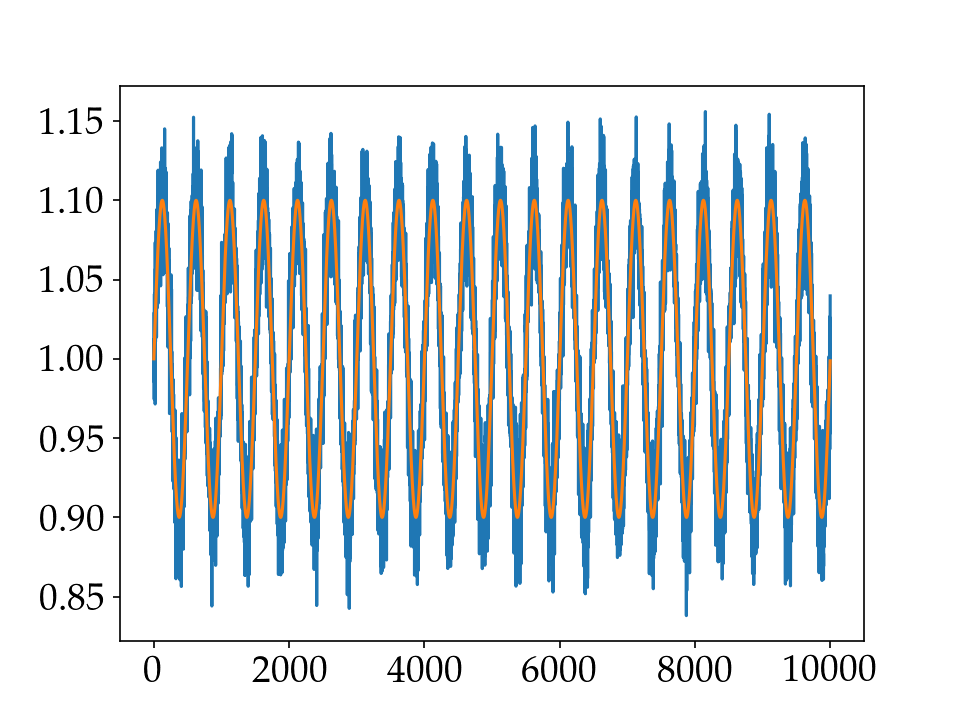

In [334]:
plt.figure()

plt.plot(x,y2)
plt.plot(x,y1)

In [1]:
# plt.figure()
# Estimate the signal to noise ratio. Check whether the
# estimate fits the input...
# Use a chunk length of 20 data points, a polynomial of degree
# one, and produce a "control plot".
# snrEsti = pyasl.estimateSNR(x, y2, 20, deg=1, controlPlot=True)
# print("Estimate of the SNR: ", snrEsti["SNR-Estimate"])



In [2]:
# plt.figure()
# Estimate the signal to noise ratio. Check whether the
# estimate fits the input...
# Use a chunk length of 20 data points, a polynomial of degree
# one, and produce a "control plot".
# snrEsti = pyasl.estimateSNR(x, y2, 20, deg=1, controlPlot=True)
# print("Estimate of the SNR: ", snrEsti["SNR-Estimate"])



## CHECKING SEDM SPEC LIVE 

In [9]:
ls

22jww_1405.ascii
Spectroscopic Analysis 2d Subsample.ipynb
ZTF18abojpnr/
ZTF18acqwdla/
ZTF19aarfkch/
ZTF19aatqzrb/
ZTF19abbwfgp/
ZTF19abpidqn/
ZTF19abrlvij/
ZTF19acctwpz/
ZTF20aasfhia/
ZTF20abybeex/
ZTF20acknpig/
ZTF20acuaqlf/
ZTF20acwgxhk/
__pycache__/
blablajwww.ascii
cadia.ascii
fitter_full_code_def.py
hgspec_targetsnonly_crr_b_ifu20220425_11_13_21_ZTF22aahhgjh.txt
lines_library.py
main.py


In [10]:
spec = ascii.read('cadia.ascii',
                              names = ['wl','flux','var'])

In [11]:
spec['wl'] /= (1+0.0029)

In [18]:
pigsnr = estimate_snr_over_band(spec, bandpass=[5900,6300], is_var = False)
pigsnr

17.35428435934192

In [19]:
pigsnr = estimate_snr_over_band(spec, bandpass=[3800,4100], is_var = True)
pigsnr

2.528995030177029

<IPython.core.display.Javascript object>


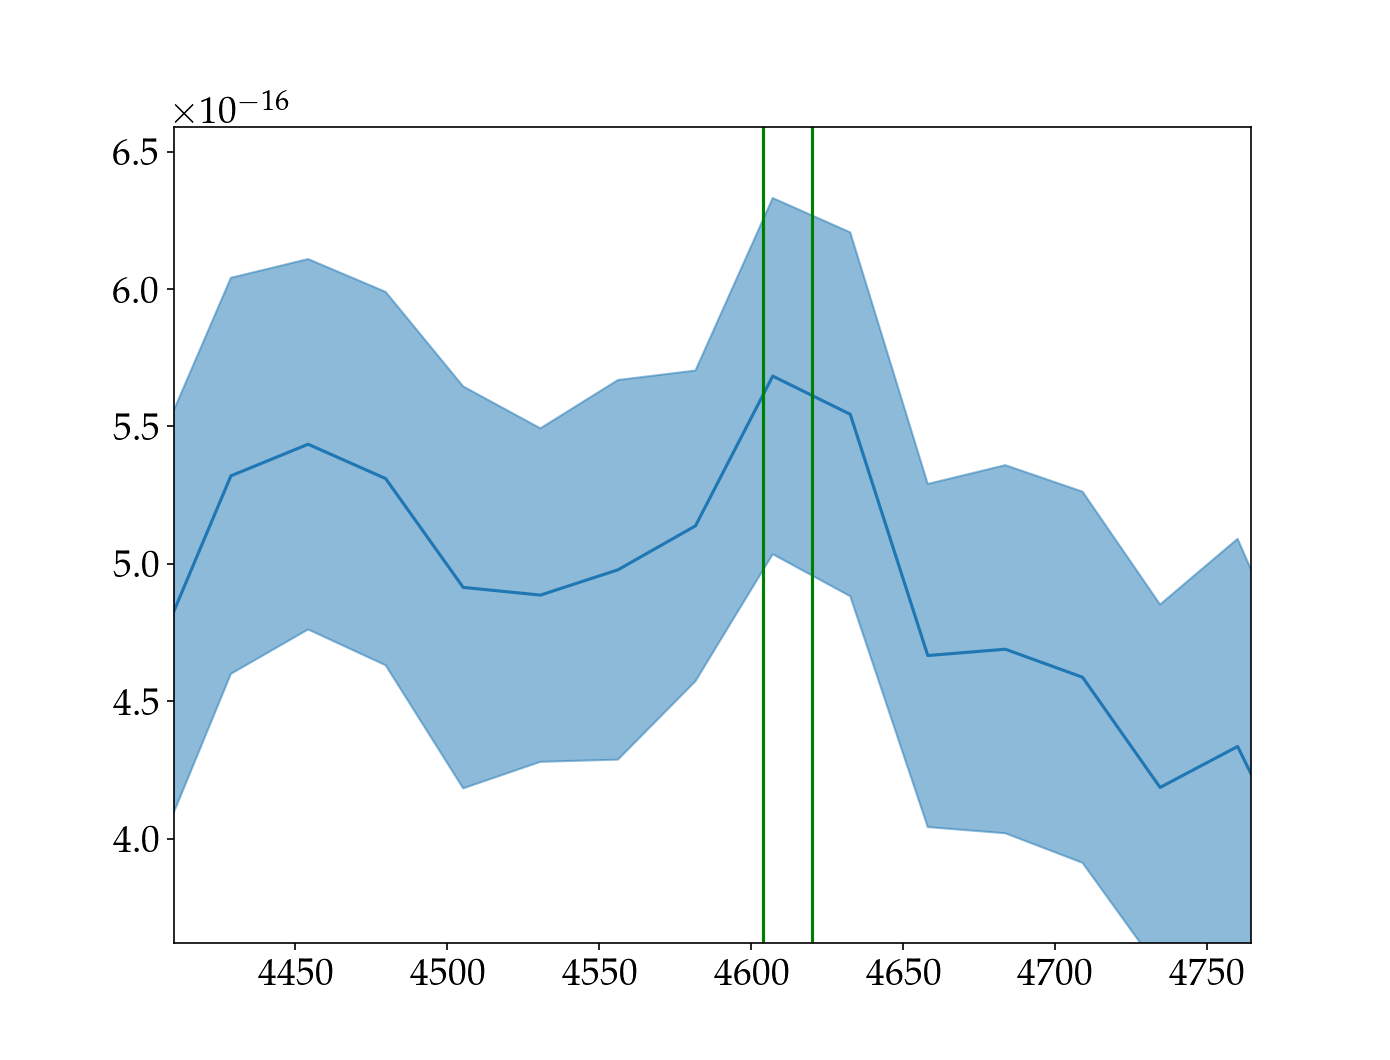

Text(4536, 1e-16, 'N V')

In [20]:

plt.figure()
# plt.title('Redshift corrected, ISM redd corrected')
h = plt.plot(spec['wl'], spec['flux'])
plt.fill_between(spec['wl'], 
                 spec['flux'] + np.sqrt(spec['var']),
                 spec['flux'] - np.sqrt(spec['var']), 
                 alpha=0.5, color=h[0].get_color())
plt.axvline(4861, color = 'red' ) 
plt.text(4861+10, 1e-16, r'H $\beta$', color = 'red')
# plt.axvline(4686, color = 'darkblue') 
plt.axvline(6563, color = 'red') 


plt.axvline(4620, color = 'green') 
plt.axvline(4604, color = 'green') 
plt.text(6563+10, 2e-16, r'H $\alpha$', color = 'red')
plt.text(4686-150, 1e-16, 'N V', color = 'green', rotation = 90)


# Checking convolution for SEDm (live) 

In [10]:
from scipy.interpolate import interp1d

In [8]:
megumi_chan  = ascii.read('/Users/r.saturn/Dropbox (Weizmann Institute)/PhD/ZTF/triggers/lris20220603_ZTF22aamgumi.spec')



In [26]:
megumi_chan.meta

OrderedDict([('comments',
              ["FILTER  = 'clear   '           / Filter",
               'EXPTIME =              500.000 / Total exposure time (sec); avg. of R&B',
               "OBJECT  = 'ZTF22aamgumi'       / User-specified object name",
               "TARGNAME= 'ZTF22aamgumi'       / Target name (from starlist)",
               "DICHNAME= '560     '           / Dichroic",
               "GRISNAME= '400/3400'           / Blue grism",
               "GRANAME = '400/8500'           / Red grating",
               'WAVELEN =        7829.41422100 / Red specified central wavelength',
               "BLUFILT = 'clear   '           / Blue filter",
               "REDFILT = 'Clear   '           / Red filter",
               "SLITNAME= 'long_1.0'           / Slitmask",
               "INSTRUME= 'LRIS+LRISBLUE'      / Camera",
               "TELESCOP= 'Keck I  '           / Telescope name",
               "BLUDET  = 'LRISB   '           / LRIS blue detector",
               "REDDE

In [27]:
FD = 59731.391794

keck_MJD = 59733.615658 
sedm_MJD = 59734.21370280

In [19]:
megumi_chan = megumi_chan[np.isnan(megumi_chan['col2']) == False]


In [38]:
megumi_chan_wl = np.linspace(3500,8500,5000)
norma_factor   = np.median(megumi_chan[(megumi_chan['col1']>=4800)&(megumi_chan['col1']<=5000)]['col2'])

megumi_chan['col2'] /= norma_factor

interpmeg = interp1d(megumi_chan['col1'], megumi_chan['col2'])

megumi_chan_flux = interpmeg(megumi_chan_wl)

In [39]:


spekmeg1   = pyasl.instrBroadGaussFast(megumi_chan_wl, megumi_chan_flux, 100, edgeHandling='firstlast', fullout=False, maxsig=None)
# megumi_chan['convSEDm']  = spekmeg1


binned_megumi_sedm    = bin_spectra(megumi_chan_wl,spekmeg1, 30 )




166
the spectra is binned for a resolution of 30


In [40]:
megumi_sedm = ascii.read('/Users/r.saturn/Dropbox (Weizmann Institute)/PhD/ZTF/triggers/spec_auto_robot_lstep1__crr_b_ifu20220604_05_07_43_ZTF22aamgumi.txt')

In [41]:
sedmnormafact = np.median(megumi_sedm[(megumi_sedm['col1']>=4800)&(megumi_sedm['col1']<=5000)]['col2'])

megumi_sedm['col2'] /= sedmnormafact




<IPython.core.display.Javascript object>


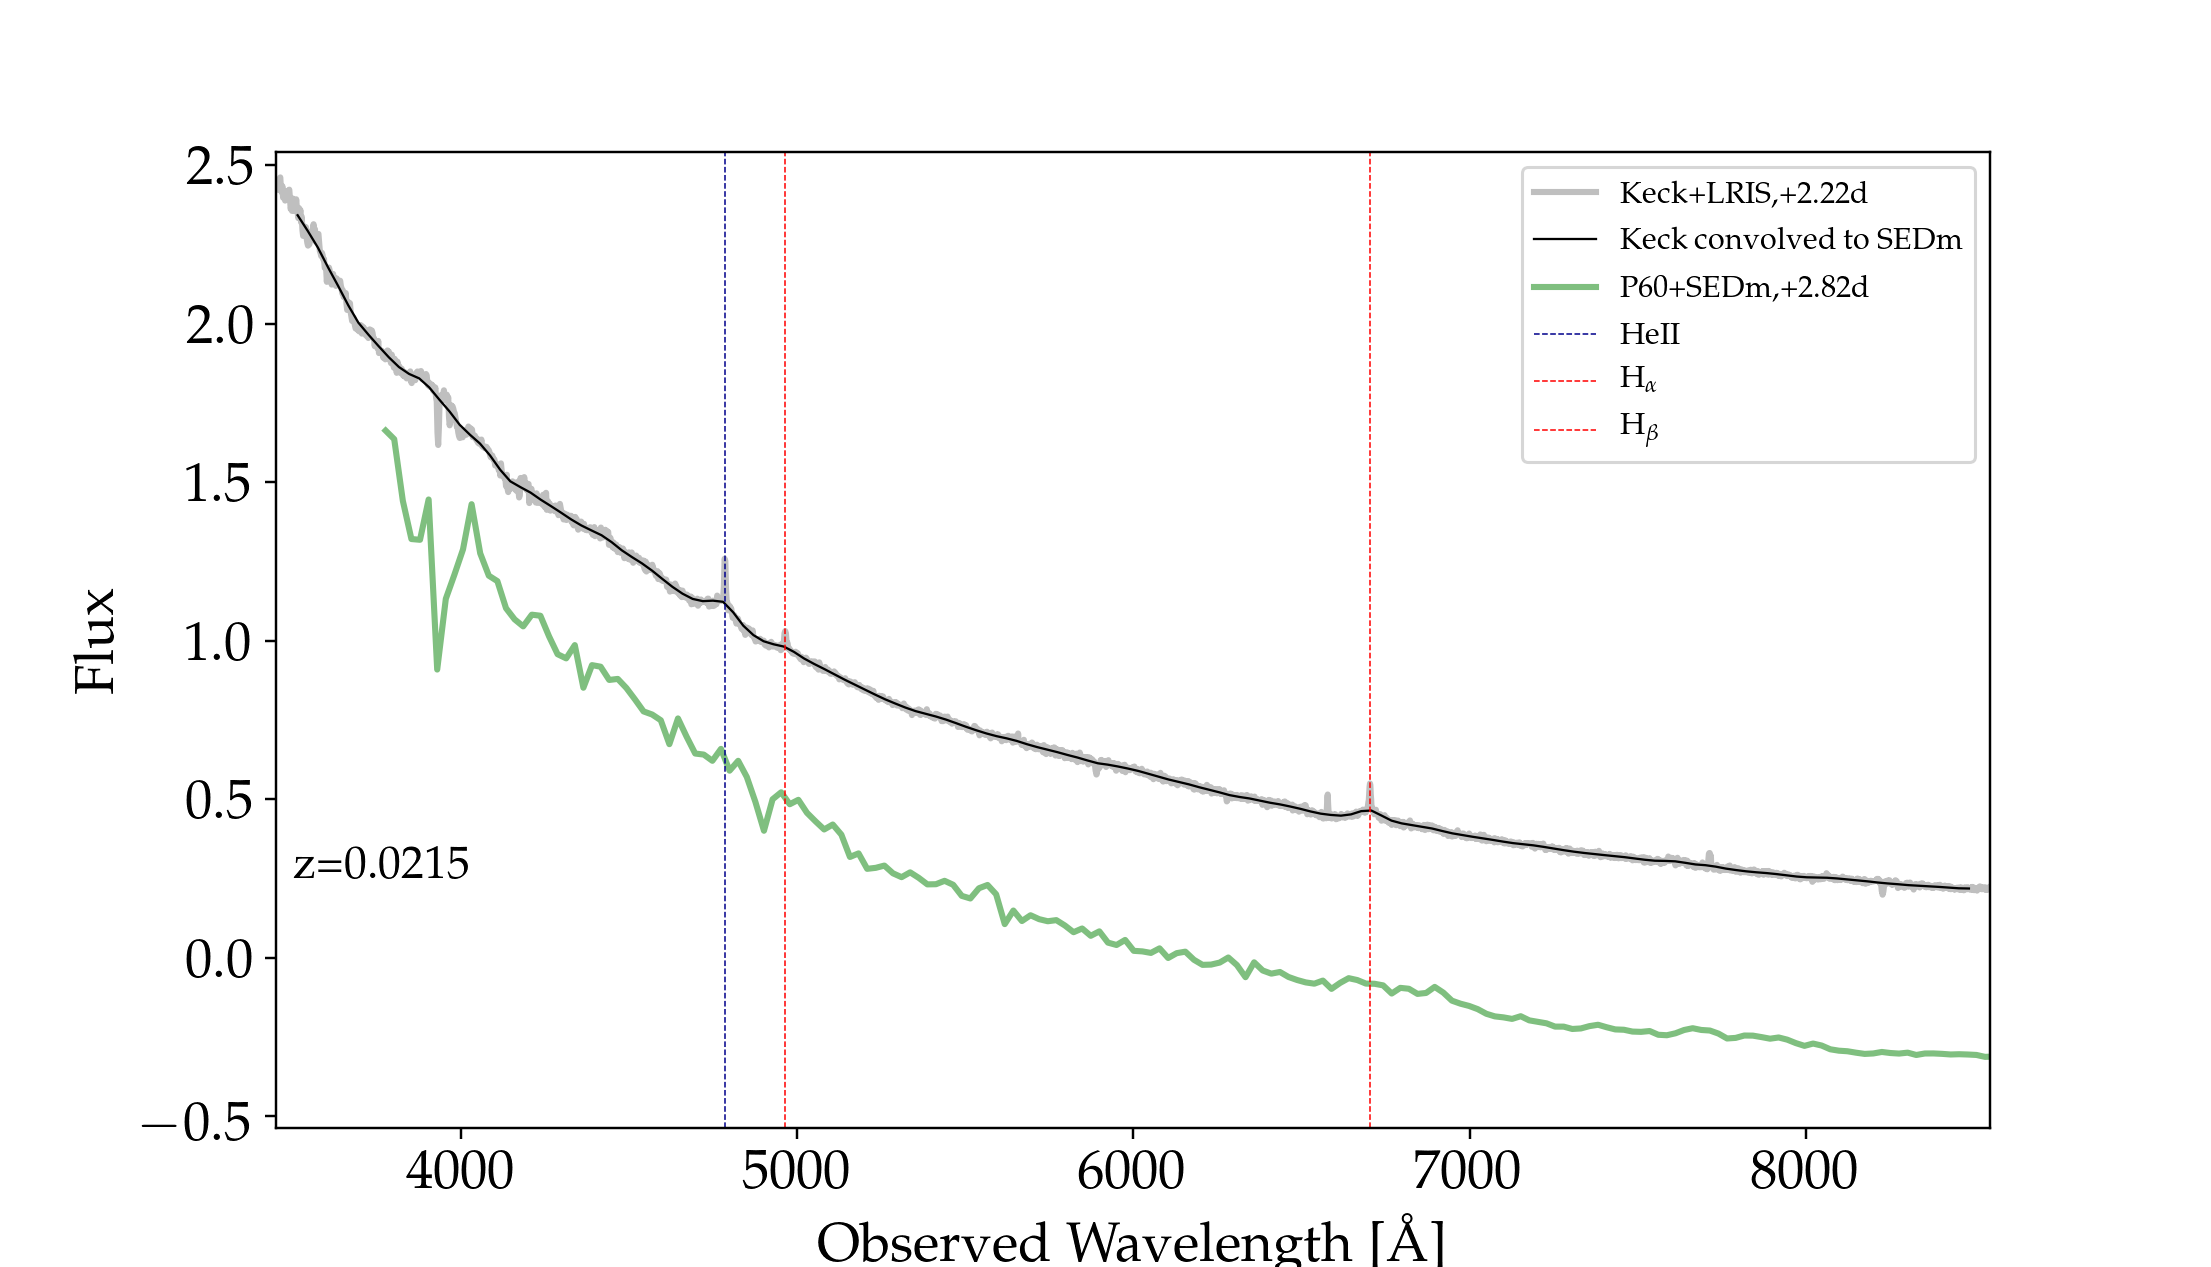

In [51]:
plt.figure()
plt.plot(megumi_chan['col1'],megumi_chan['col2'], color = 'grey', lw = 2, alpha = 0.5, label = f'Keck+LRIS,+{keck_MJD-FD:.2f}d')
plt.plot(binned_megumi_sedm['bin_wl'],binned_megumi_sedm['bin_flux'], lw = 0.75,
         color = 'black', label = 'Keck convolved to SEDm')
plt.plot(megumi_sedm['col1'],megumi_sedm['col2']-0.5, color = 'green', lw = 2, alpha = 0.5, label = f'P60+SEDm,+{sedm_MJD-FD:.2f}d')

plt.text(3500,0.25,'z=0.0215', size = 15)
plt.axvline(4686*(1+0.0215),ls = '--', lw = 0.5, color = 'darkblue',label = 'HeII') 
plt.axvline(6563*(1+0.0215),ls = '--', lw = 0.5, color = 'red', label = r'H$_\alpha$') 
plt.axvline(4861*(1+0.0215),ls = '--', lw = 0.5, color = 'red', label = r'H$_\beta$') 

plt.xlabel('Observed Wavelength [Å]', size = 18)
plt.ylabel('Flux', size = 18 )
plt.xlim([3450,8550])
plt.legend()